In [10]:
# dependencies

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

In [11]:
# load the data
DATA_SOURCE = "my_library.csv"
data = pd.read_csv(DATA_SOURCE, memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item ID (Read-Only)   551 non-null    object 
 1   original ID           40 non-null     object 
 2   type                  551 non-null    object 
 3   created (Read-Only)   551 non-null    object 
 4   updated (Read-Only)   551 non-null    object 
 5   read                  551 non-null    bool   
 6   notes                 23 non-null     object 
 7   color                 74 non-null     object 
 8   flag                  551 non-null    bool   
 9   ratings               0 non-null      float64
 10  doi                   532 non-null    object 
 11  patent_id             0 non-null      float64
 12  pmid                  504 non-null    float64
 13  pmcid                 198 non-null    object 
 14  arxiv                 1 non-null      float64
 15  file (Read-Only)      4

In [12]:
import gc
df = data[['title','abstract']]
del data
gc.collect()

df.dropna(inplace=True)
df.drop_duplicates(subset=['abstract'],inplace=True)

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


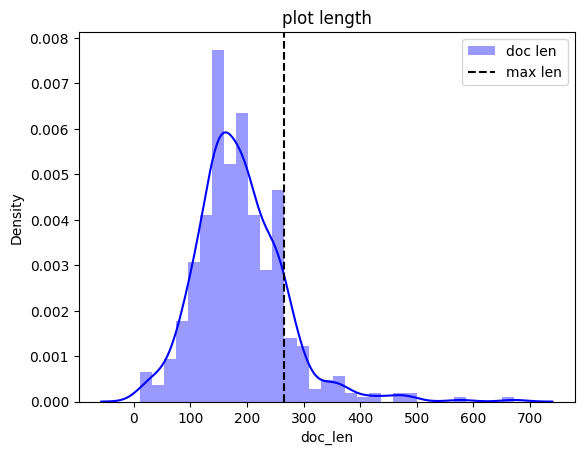

In [13]:
df['doc_len'] = df['abstract'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [14]:
from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('msmarco-distilbert-dot-v5')
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')


In [9]:
import faiss
encoded_data = model.encode(df.abstract.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'papers.index')

In [4]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['title'] = info['title']
    return meta_dict
    
def search(query, top_k, index, model):
    print(index)
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [57]:
import os
import faiss
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')



FAISS_INDEX_PATH = "/Users/uri/Desktop/Projects/JCARLO/demo_01"


indexfile = os.path.join(FAISS_INDEX_PATH,'papers.index')
index_loaded = faiss.read_index(indexfile, faiss.IO_FLAG_ONDISK_SAME_DIR)

query = "Copper inhibits FDX1-mediated protein lipoylation"
results = search(query, top_k=5, index=index_loaded, model=model)

print("\n")
for result in results:
    print(result['title'])
    print("--------------------------------")

>>>> Results in Total Time: 0.0589289665222168


Fatty acid oxidation protects cancer cells from apoptosis by increasing mitochondrial membrane lipids
--------------------------------
Role of non‐selective adenosine receptor blockade and phosphodiesterase inhibition in cisplatin‐induced nephrogonadal toxicity in rats
--------------------------------
FDX1-dependent and independent mechanisms of elesclomol-mediated intracellular copper delivery
--------------------------------
Elesclomol induces copper‐dependent ferroptosis in colorectal cancer cells via degradation of ATP7A
--------------------------------
The oncology drug elesclomol selectively transports copper to the mitochondria to induce oxidative stress in cancer cells
--------------------------------


### FDX1 is directly targeted by Elesclomol
 
SPECIFIC ANSWER: <u>Mitochondrial metabolism promotes adaptation to proteotoxic stress (2019)</u>

OTHER ANSWER: FDX1-dependent and independent mechanisms of elesclomol-mediated intracellular copper delivery (2023)
 
### Ferroptosis and Apoptosis are interconnected
 
SPECIFIC ANSWER: <u>BAX-dependent mitochondrial pathway mediates the crosstalk between ferroptosis and apoptosis (2020)</u>
 
OTHER ANSWER: Iron-Sulfur Clusters: A Key Factor of Regulated Cell Death in Cancer (2022)
 
 
### Copper inhibits FDX1-mediated protein lipoylation
 
SPECIFIC ANSWER: <u>Copper induces cell death by targeting lipoylated TCA cycle proteins (2022)</u>
Dimensions API


In [16]:
import papers.index as indx

print(indx)

ModuleNotFoundError: No module named 'papers'

In [15]:
from tqdm.auto import tqdm
tqdm.pandas()

def get_embeddings(documents):

    
    sentences  = [documents]
    # encoded_data = model.encode(df.Plot.tolist())
    sentence_embeddings = model.encode(sentences)
    # encoded_data = np.asarray(encoded_data.astype('float32'))
    encod_np_array = np.array(sentence_embeddings.astype('float32'))
    encod_list = encod_np_array.tolist() # attempt removing this?
    return encod_list[0]

In [16]:
df['vector'] = df['abstract'].progress_apply(get_embeddings)

  0%|          | 0/502 [00:00<?, ?it/s]

In [17]:
from elasticsearch import Elasticsearch

es = Elasticsearch(
    "https://localhost:9200/",
    basic_auth=("elastic", "Z1*nfDFd1YhmgLg8w1qo"),
    ca_certs="/Users/uri/Desktop/Dev/elasticsearch-8.10.4/config/certs/http_ca.crt"
)

es.ping()

True

In [42]:
from indeces_elastic.mapping_distilbert_dot_v5 import index_mapping

es.indices.create(index="papers-dot-v52", mappings=index_mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'papers-dot-v52'})

In [128]:
encoded_data = model.encode(df['abstract'].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
encoded_data
type(encoded_data)

numpy.ndarray

In [145]:
# encoded_data
df

title  \
6    The Role of Bmp2 in the Maturation and Mainten...   
7    Genetic evidence that FGFs have an instructive...   
9    Cell stress in cortical organoids impairs mole...   
10   Specification of positional identity in forebr...   
11   The aging skin microenvironment dictates stem ...   
..                                                 ...   
546  Machine learning powers biobank-driven drug di...   
547  Haploinsufficiency leads to neurodegeneration ...   
548  Artificial intelligence for natural product dr...   
549  MIBiG 3.0: a community-driven effort to annota...   
550  Intracellular transport of phosphatidylcholine...   

                                              abstract  doc_len  \
6    Bone morphogenetic proteins (BMPs) are key reg...      260   
7    The developing limb bud possesses a small ridg...      487   
9    Cortical organoids are self-organizing three-d...      173   
10   Human brain organoids generated with current t...      169   
11   Aging manifests with architectural alteration ...      238   
..                                                 ...      ...   
546  Drug hunters are moving into the clinic with h...       26   
547  Human ALS/FTD patient iPSC-derived neurons are...      192   
548  Developments in computational omics technologi...      181   
549  With an ever-increasing amount of (meta)genomi...      197   
550  We have used pulse-chase labeling of Chinese h...      104   

                                                vector  
6    [-0.29539990425109863, -0.12597444653511047, 0...  
7    [-0.4486575424671173, -0.1807374656200409, 0.0...  
9    [0.01713123917579651, 0.0666685551404953, -0.3...  
10   [-0.1263190656900406, -0.1508781462907791, -0....  
11   [-0.485004186630249, 0.18356505036354065, -0.7...  
..                                                 ...  
546  [-0.25244268774986267, 0.25318944454193115, -0...  
547  [-0.3836013972759247, -0.0911366194486618, -0....  
548  [-0.5859295129776001, -0.26065778732299805, -0...  
549  [0.013356983661651611, 0.152140811085701, -0.2...  
550  [-0.35069334506988525, -0.31081464886665344, -...  

[502 rows x 4 columns]

In [133]:
type(encoded_data)
# df.drop(columns=['vector'], inplace=True)
df['vector']=encoded_data.tolist()
# df.shape


In [169]:
# for idx, row in df.iterrows():
#     row['vector'] = 1
# # print(len(df['vector']), len(encoded_data))
# # for i in range(len(encoded_data)):
# #     idx = i + 6
# #     df.loc[idx, 'vector']
# # for i in range()
# # encoded_data
# # df['vector']
# gc.collect()

pd.options.display.float_format = '{:,.5f}'.format
print(encoded_data[0][0])
encoded_data.tolist()[0][0]
# new_df = pd.DataFrame({'vector': encoded_data})
# new_df
# df.update(new_df)

-0.2953999


-0.29539990425109863

In [172]:
df1 = df['vector'].astype("float32")

ValueError: setting an array element with a sequence.

In [183]:
# encoded_data.round(3).tolist()

df['vector'] = encoded_data.astype('float16').tolist()
# len(str(df.iloc[0, 3][0]))

In [184]:
df
0.2953997552394867
0.29541015625

title  \
6    The Role of Bmp2 in the Maturation and Mainten...   
7    Genetic evidence that FGFs have an instructive...   
9    Cell stress in cortical organoids impairs mole...   
10   Specification of positional identity in forebr...   
11   The aging skin microenvironment dictates stem ...   
..                                                 ...   
546  Machine learning powers biobank-driven drug di...   
547  Haploinsufficiency leads to neurodegeneration ...   
548  Artificial intelligence for natural product dr...   
549  MIBiG 3.0: a community-driven effort to annota...   
550  Intracellular transport of phosphatidylcholine...   

                                              abstract  doc_len  \
6    Bone morphogenetic proteins (BMPs) are key reg...      260   
7    The developing limb bud possesses a small ridg...      487   
9    Cortical organoids are self-organizing three-d...      173   
10   Human brain organoids generated with current t...      169   
11   Aging manifests with architectural alteration ...      238   
..                                                 ...      ...   
546  Drug hunters are moving into the clinic with h...       26   
547  Human ALS/FTD patient iPSC-derived neurons are...      192   
548  Developments in computational omics technologi...      181   
549  With an ever-increasing amount of (meta)genomi...      197   
550  We have used pulse-chase labeling of Chinese h...      104   

                                                vector  
6    [-0.29541015625, -0.1259765625, 0.2861328125, ...  
7    [-0.44873046875, -0.1807861328125, 0.025756835...  
9    [0.0171356201171875, 0.066650390625, -0.338378...  
10   [-0.1263427734375, -0.15087890625, -0.38867187...  
11   [-0.485107421875, 0.18359375, -0.70166015625, ...  
..                                                 ...  
546  [-0.25244140625, 0.253173828125, -0.0657958984...  
547  [-0.383544921875, -0.09112548828125, -0.455566...  
548  [-0.5859375, -0.2607421875, -0.44384765625, -0...  
549  [0.01335906982421875, 0.152099609375, -0.23925...  
550  [-0.3505859375, -0.310791015625, -0.392578125,...  

[502 rows x 4 columns]

In [41]:
from indeces_elastic.mapping_distilbert_dot_v5 import index_mapping
index_mapping

{'properties': {'title': {'type': 'text'},
  'abstract': {'type': 'text'},
  'doc_len': {'type': 'long'},
  'vector': {'type': 'dense_vector',
   'dims': 768,
   'index': True,
   'similarity': 'dot_product'}}}

In [43]:
elk_data = df.to_dict("records")

for record in elk_data:
    print(np.float32(record['vector'][0]), record['vector'][0])
    record['vector'] = np.float16(record['vector']).tolist()
    print(record['vector'])
    try:
        es.index(index="papers-dot-v52", document=record)
    except Exception as e:
        print(e)

-0.29539976 -0.2953997552394867
[-0.29541015625, -0.1259765625, 0.2861328125, -0.52001953125, 0.1143798828125, -0.4990234375, -0.223388671875, -0.146728515625, 0.12469482421875, -0.0859375, -0.3876953125, 0.036590576171875, 0.00189971923828125, -0.09375, -0.2076416015625, 0.93505859375, 0.59814453125, -0.451904296875, 0.91748046875, 0.07293701171875, -0.0238800048828125, -0.1036376953125, 0.1822509765625, 0.4267578125, -0.33154296875, 0.343017578125, -0.1002197265625, -0.2076416015625, 0.0987548828125, -0.4609375, -0.177001953125, 0.2108154296875, -0.23095703125, -0.1300048828125, -0.29345703125, -0.1405029296875, 0.12164306640625, 0.1856689453125, 0.372314453125, 0.1602783203125, -0.32421875, -0.1165771484375, 0.362060546875, 0.65234375, -0.86328125, -0.25341796875, 0.1768798828125, 0.12646484375, -0.0452880859375, 0.365478515625, -0.349609375, 1.0947265625, 0.8173828125, 0.038543701171875, 0.1048583984375, 0.023193359375, 0.326171875, -0.41845703125, 0.202880859375, -0.02726745605468

In [40]:
es.count(index="papers-dot-v5")

ObjectApiResponse({'count': 0, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})